# Bert-Based Model - English

In we want to use BERT and leverage contextual word embeddings, following on from the last CNN LSTM model we had built. Instead of  CNN utterance-level classifier we are building a  BERT-based text classifier here. The domain difference from conversational data is one possible downside to using BERT. Explore some techniques to efficiently transfer the knowledge from conversational data and to improve model performance on Hate Speech Classification.

In [ ]:
!pip install bert-for-tf2==0.14.4 > /dev/null

In [ ]:
import os, glob, time
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools, random
from collections import Counter
import pdb,os,sys

In [ ]:
tf.__version__

'2.3.0'

# Data

Here we load 'dataset_en_csv' and format the data into train, test, validation sets. 


In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset_en.csv to dataset_en.csv
User uploaded file "dataset_en.csv" with length 18035982 bytes


In [ ]:
df = pd.read_csv('dataset_en.csv')
print(df.columns,'\n',df.head(5))
df.drop(['text_id','text','ekphrasis_clean_text'],inplace=True,axis=1)
df.rename(columns={'basic_clean_text':'text'},inplace=True)
df['class'] = df['class'].astype(int)
df = df[df['text'].notna()]
df = df.sample(n=len(df), random_state=42)
dummies = pd.get_dummies(df["class"])
df['text_len'] = df.apply(lambda x: len(x.text.split()), axis=1)
df = df[df['text_len']<200]
df.drop(['text_len'],inplace=True,axis=1)
res = pd.concat([df, dummies], axis=1)
res.head()
res['tag_arg_max'] = res.apply(lambda x: np.argmax(np.asarray(x[2:],dtype=np.float32)),axis=1)

one_hot_encoding_dict = {}
for row in res.values:
    one_hot_encoding_dict[row[0]] = row[-1]
one_hot_encoding_dict
res = res.drop(columns=['class','tag_arg_max'])
res.head()

Index(['text_id', 'text', 'class', 'text_len', 'ekphrasis_clean_text',
       'basic_clean_text'],
      dtype='object') 
          text_id  ...                                   basic_clean_text
0  hasoc_en_4939  ...  gangster sets out fulfill his father dream bec...
1   hasoc_en_177  ...  that not white supremacy though . that means w...
2  hasoc_en_1061  ...  sit his ass down ! tape his fingers and duct -...
3   hasoc_en_663  ...  absolutely right that the government does all ...
4  hasoc_en_1858  ...  timewear analogue white round dial leather str...

[5 rows x 6 columns]


,text,0,1,2
12590,user sick bitch !,0,0,1
41333,user user user user user this unacceptable ! a...,0,1,0
43275,donald trump pulls out global compact migration,1,0,0
48009,this bitch stupid assface . forcing wake resid...,0,1,0
21648,user : like whats up? bitch ? ! & # ;\( & # ;o...,0,0,1


In [ ]:
int(len(res)*0.80),int(len(res)*0.90)
#40304, 45342

(40295, 45332)

In [ ]:
train = res[0:40296]
val = res[40296:45333]
test = res[45333:]
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)
test.to_csv("test.csv",index=False)
train = pd.read_csv("train.csv")
valid = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.shape,test.shape,val.shape

((40296, 4), (5036, 4), (5037, 4))

In [ ]:
train.iloc[0]['text']

'user sick bitch !'

# Get Pre-trained BERT model 

We would be using `uncased_L-12_H-768_A-12` version of BERT which has 12 layers and returns 768 hidden parameters.

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-08-29 03:25:11--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.74.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M  87.6MB/s    in 4.4s    

2020-08-29 03:25:16 (87.6 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model")

In [ ]:
!mv uncased_L-12_H-768_A-12/ model

In [ ]:
class ProcessData:
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.train = train
        self.test = test
        self.tokenizer = tokenizer
        self.classes = classes
        self.max_seq_len = max_seq_len
        if isinstance(self.test, list):
        	self.X = self.list_to_examples(self.test)
        else:
            self.max_seq_len = 0
            self.tokenizer = tokenizer

            self.classes = classes    
            ((self.train_x, self.train_y), (self.test_x, self.test_y), (self.val_x, self.val_y)) = map(self.convert_text_to_examples, [train, test, val])

            self.max_seq_len = min(self.max_seq_len, max_seq_len)
            print("Max Seq Len", self.max_seq_len)
            self.train_x, self.test_x, self.val_x = map(self.add_pad, [self.train_x, self.test_x, self.val_x])

    def convert_text_to_examples(self, df):
        """
        converts a dataframe of text and classes into usable tokens for BERT input
        """
        x, y = [], []
    
        for _, row in tqdm(df.iterrows()):
            text = row['text']
            label = np.asarray(row[1:],dtype=np.float32)
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(label)

        return np.array(x), np.array(y)

    def add_pad(self, ids):
        """
        Add padding to the sequence  
        """
        x = []
        for input_ids in ids:
            input_ids = list(input_ids[:min(len(input_ids), self.max_seq_len - 1)])
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

    def list_to_examples(self, alist):
        """
        Convert a list of text sentences to sequences with paddings. 
        """
        x, y = [], []
    
        for text in tqdm(alist):
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            x.append(token_ids)
        return self.add_pad(x)


In [ ]:
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing of Data

Preprocessing the Data as BERT would expect.

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [ ]:
classes = 3
start_time = time.time()
data = ProcessData(train, test, tokenizer, classes, max_seq_len=128)
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

40296it [00:22, 1791.17it/s]
5036it [00:02, 1813.83it/s]
5037it [00:02, 1799.38it/s]


Max Seq Len 128
Time Taken: 00:00:28


In [ ]:
len(data.test_x[0])

128

## Creating Model

In [ ]:
from tensorflow.keras.layers import Lambda, Input, LSTM, RepeatVector, Dense, Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding, Reshape, concatenate, Conv2D, BatchNormalization, MaxPool2D, Flatten

HIDDEN_SIZE = 3
drop = 0.2
# https://github.com/kpe/bert-for-tf2
def create_model(max_seq_len, bert_ckpt_file):
    """
    Use the pre-trained BERT model over LSTM
    """
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    # BERT out
    bert_output = bert(input_ids)
    # to get the output dmin of form (none,128,768) --> (none,768) 
    lmd_out = Lambda(lambda seq: seq[:, 0, :])(bert_output)
    dense_1 = Dense(units=768, activation="tanh")(lmd_out)
    dropout_1 = Dropout(0.5)(dense_1)


    # LSTM expect (batch_size, timesteps, features) or (num_samples, timesteps, channels) 
    # using BERT output (none,128,768) to distribute over time(128) for LSTM
    timexx = TimeDistributed(Dense(max_seq_len))(bert_output)
    # Bidirectional 1
    b1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(timexx)
    # Bidirectional 2
    b2 = Bidirectional(LSTM(HIDDEN_SIZE))(b1)
    # Dense layer (dense_2)
    dense_2 = Dense(HIDDEN_SIZE)(b2)
    # dropout_2
    dropout_2 = Dropout(drop)(dense_2)


    # concatenate 2 final layers
    y = concatenate([dropout_1, dropout_2],axis = -1)
    # output
    out = Dense(HIDDEN_SIZE)(y)
    out = Activation('sigmoid')(out)


    model = Model(inputs=input_ids, outputs=out)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
        
    return model

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)
model.summary()

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f237717f0f0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________

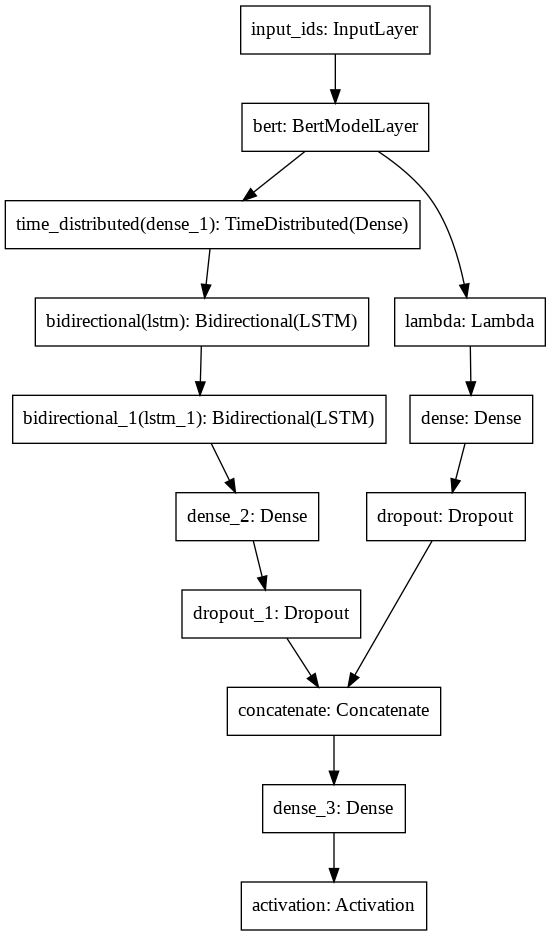

In [ ]:
plot_model(model, to_file='model.png')

From the above figure, we can understand that, the contextual information is being processed by BERT model and is being passed onto by the BiLSTM layers via timedistributed as LSTM only expect (batch_size, timesteps, features)  or (num_samples, timesteps, channels). The LSTM layers carry out the classification task and results are passed though sigmoid activation layer though which each class is decided.

## Training

In [ ]:
data.train_y.shape

(40296, 3)

In [ ]:
def train_test_input_fn(test_record, batch_size=256):
    """
    Convert the input sequences to tensor slices, each of batch_size size 
    """
    if test_record is not None:
        test_record_tnsr = tf.data.Dataset.from_tensor_slices((test_record,np.eye(3)[[0]*len(data.X)]))
        test_record_tnsr = test_record_tnsr.batch(batch_size)
        return test_record_tnsr
    else:
        # covert data into tensor datasets
        dataset_train = tf.data.Dataset.from_tensor_slices((data.train_x,data.train_y))
        dataset_test = tf.data.Dataset.from_tensor_slices((data.test_x,data.test_y))
        dataset_val = tf.data.Dataset.from_tensor_slices((data.val_x,data.val_y))
        # Shuffle, repeat, and batch the examples.
        dataset_train = dataset_train.cache()
        dataset_train = dataset_train.shuffle(1000, reshuffle_each_iteration=True)
        dataset_train = dataset_train.repeat()
        dataset_train = dataset_train.batch(batch_size)
        # dataset_test = dataset_test.cache()
        # dataset_test = dataset_test.shuffle(1000, reshuffle_each_iteration=True)
        # dataset_test = dataset_test.repeat()
        dataset_test = dataset_test.batch(batch_size)
        dataset_val = dataset_val.cache()
        dataset_val = dataset_val.shuffle(1000, reshuffle_each_iteration=True)
        dataset_val = dataset_val.repeat()
        dataset_val = dataset_val.batch(batch_size)
        # Return the dataset.
        return dataset_train,dataset_test,dataset_val


In [ ]:
# To check if TPU is avaiable
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
    print('TPU not found')

Found TPU at: grpc://10.30.37.194:8470


In [ ]:
# Configure and connect to TPU.
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# TPU initialization 
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)


INFO:tensorflow:Initializing the TPU system: grpc://10.30.37.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.30.37.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
start_time = time.time()
with strategy.scope():
  model = create_model(data.max_seq_len, bert_ckpt_file)
  model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'], )
# setting batch size to 121 as it perfecty divides test data length
train_dataset, test_dataset, val_dataset = train_test_input_fn(None, 121)
checkpoint = ModelCheckpoint('bert-en-weights.best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [checkpoint,earlystop]
model.fit(train_dataset,
          epochs=20,
          steps_per_epoch = int(len(train)/121), #len(train)/121
          validation_data=val_dataset,
          validation_steps=int(len(val)/121), # #len(val)/121
          callbacks=[callbacks_list]
          )
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f22df5bce10> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/20
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


  2/333 [..............................] - ETA: 21s - loss: 1.1901 - accuracy: 0.3471WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_train_batch_end` time: 0.1189s). Check your callbacks.


333/333 [==============================] - ETA: 0s - loss: 0.8188 - accuracy: 0.6299WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0037s vs `on_test_batch_end` time: 0.0415s). Check your callbacks.



Epoch 00001: val_accuracy improved from -inf to 0.72385, saving model to bert-en-weights.best.hdf5
333/333 [==============================] - 57s 171ms/step - loss: 0.8188 - accuracy: 0.6299 - val_loss: 0.6320 - val_accuracy: 0.7238
Epoch 2/20
333/333 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7321
Epoch 00002: val_accuracy improved from 0.72385 to 0.75831, saving model to bert-en-weights.best.hdf5
333/333 [==============================] - 46s 140ms/step - loss: 0.6189 - accuracy: 0.7321 - val_loss: 0.5710 - val_accuracy: 0.7583
Epoch 3/20
333/333 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7571
Epoch 00003: val_accuracy did not improve from 0.75831
333/333 [==============================] - 43s 130ms/step - loss: 0.5665 - accuracy: 0.7571 - val_loss: 0.5777 - val_accuracy: 0.7557
Epoch 4/20
333/333 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.7712
Epoch 00004: val_accuracy improved from 0.75831 to 0.

In [ ]:
score = model.evaluate(test_dataset,steps=int(len(test)/121)) #len(test)/121

 2/41 [>.............................] - ETA: 1s - loss: 0.5290 - accuracy: 0.7851WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0467s). Check your callbacks.


41/41 [==============================] - 2s 48ms/step - loss: 0.4806 - accuracy: 0.8010


In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 80.1048219203949


The overall accuracy is 80.26%

## Evaluation

In [ ]:
# Generate predictions for the test data
y_pred = model.predict(test_dataset) # 55902/121

In [ ]:
y_test = [np.asarray(row[1:],dtype=np.float32) for row in test.values]
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
len(y_test),len(y_pred)

(5036, 5036)

In [ ]:
# Build Confusion Matrix
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def gen_confusion_matrix(y_test = None, y_pred = None, classes = 3):
    if y_test is None:
        y_test = self.y_test
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    if classes ==3:
        matrix_proportions = np.zeros((3,3))
        for i in range(0,3):
            matrix_proportions[i,:] = confusion_mat[i,:]/float(confusion_mat[i,:].sum())
        names=['Hate','Offensive','Neither']
        confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
        plt.figure(figsize=(5,5))
        seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
        plt.ylabel(r'True categories',fontsize=14)
        plt.xlabel(r'Predicted categories',fontsize=14)
        plt.tick_params(labelsize=12)
    if classes == 2:
        matrix_proportions = np.zeros((2,2))
        for i in range(0,2):
            matrix_proportions[i,:] = confusion_mat[i,:]/float(confusion_mat[i,:].sum())
        names=['Hate','Neither']
        confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
        plt.figure(figsize=(5,5))
        seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
        plt.ylabel(r'True categories',fontsize=14)
        plt.xlabel(r'Predicted categories',fontsize=14)
        plt.tick_params(labelsize=12)

def gen_report(y_test = None, y_pred = None):
    acc = accuracy_score(y_test, y_pred)
    return acc, classification_report(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


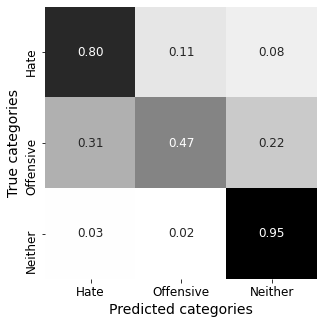

In [ ]:
gen_confusion_matrix(y_test,y_pred,classes=3)

In [ ]:
print('Accuracy: ',gen_report(y_test,y_pred)[0])
print(gen_report(y_test,y_pred)[1])

Accuracy:  0.801032565528197
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1648
           1       0.67      0.47      0.55      1060
           2       0.86      0.95      0.90      2328

    accuracy                           0.80      5036
   macro avg       0.77      0.74      0.75      5036
weighted avg       0.79      0.80      0.79      5036



### Test Case

In [ ]:
classes = 3
from tensorflow.keras.models import load_model
start_time = time.time()
text = ["A gangster sets out to fulfill his father’s dream of becoming a doctor."]
data = ProcessData(train = None, test=text, tokenizer=  tokenizer, classes= classes, max_seq_len=128)
print(type(data.X))

tensor_test_instance = train_test_input_fn(data.X, batch_size=121)
new_model = load_model('bert-en-weights.best.hdf5')
results = new_model.predict(tensor_test_instance)
print(results)
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

100%|██████████| 1/1 [00:00<00:00, 1726.76it/s]

<class 'numpy.ndarray'>


[[0.82852495 0.19178656 0.00908119]]
Time Taken: 00:00:09
